<a href="https://colab.research.google.com/github/5sleepy/IrisNN/blob/main/firstNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
iris = load_iris()
X = iris.data  # num of features
y = iris.target  # num of labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split dataset into train and test

# scale data such that mean = 0, std = 1 for each feature
# makes training faster and reduces pitfalls of gradient descent
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [3]:
# convert to pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32) # float bc features are cts
y_train = torch.tensor(y_train, dtype=torch.long) # long bc optim fcts (cross entropy loss & negative log likelihood loss) expect y-val to be longs

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [4]:
# create pytorch dataloaders to use with nn
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # shuffle true to prevent learning order-based patterns, improve sgd, and reduce overfitting
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # shuffle false because consistent testing and unnecessary since weights and biases aren't adjusted


In [5]:
# define neural net architecture

class myNN(nn.Module):

  # described is a 3->8->8->4 neural net
  def __init__(self, input_size=4, hidden_1=8, hidden_2=8, output_size=3):
    super(myNN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_1)
    self.fc2 = nn.Linear(hidden_1, hidden_2)
    self.fcOut = nn.Linear(hidden_2, output_size)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fcOut(x)
    return x


In [6]:
# instantiate neural net, loss function and optimizer

model = myNN()
criterion = nn.CrossEntropyLoss() # appropriate loss function, as the nn is a classification model -> multinoulli cross-entropy
optimizer = optim.Adam(model.parameters(),lr=0.01) # implements the ADAM optimization algorithm to adjust weights according to gradients from backpropagation

In [7]:
# train the model
losses = []
epochs = 100

for epoch in range(epochs):
  model.train() # set model to training mode
  for X_batch, y_batch in train_loader:
    optimizer.zero_grad() # zero the gradients (necessary because gradients are accumulated in backwards passes, which is useful for RNNs, but not for us rn)
    output = model(X_batch) # forward pass of the features
    loss = criterion(output, y_batch) # calculate the loss
    loss.backward() # backward pass (backprop)
    optimizer.step() # update weights and biases

  # print loss every 10 epochs
  if (epoch+1) % 10 == 0:
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

    # save a checkpoint every 10 epochs containing data necessary to restart training
    checkpoint = {
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss.item()
    }
    torch.save(checkpoint, f"checkpoint_epoch_{epoch+1}.pth")
  losses.append(loss.item())


Epoch 10, Loss: 0.2663
Epoch 20, Loss: 0.1171
Epoch 30, Loss: 0.0921
Epoch 40, Loss: 0.0885
Epoch 50, Loss: 0.0715
Epoch 60, Loss: 0.0589
Epoch 70, Loss: 0.0612
Epoch 80, Loss: 0.0201
Epoch 90, Loss: 0.0185
Epoch 100, Loss: 0.0206


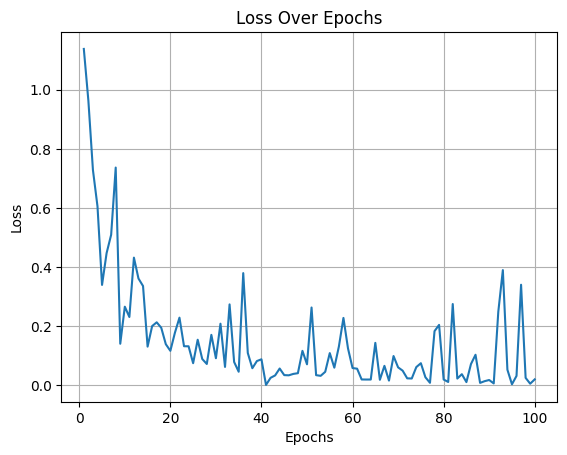

In [8]:
# Plotting the loss over epochs
plt.plot(range(1, epochs+1), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.grid(True)
plt.show()


In [9]:
# loss graph shows that after around 20 epochs, the model is adjusting to the noise in the dataset rather than any patterns
# load data from epoch 20
checkpoint = torch.load("checkpoint_epoch_20.pth")

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [10]:
# evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for X_batch, y_batch in test_loader:
    output = model(X_batch)
    _, predicted = torch.max(output, 1) # torch.max returns a tuple of 2 tensors: max values tensor and index of the max values tensor
    total += y_batch.size(0) # gets the number of items in the batch (since y_batch is a tensor of shape (16, 4))
    # compares the predicted and actual labels, returning a tensor of boolean values. sum() counts the number of correct predictions, and item() converts from tensor to python scalar
    correct += (predicted == y_batch).sum().item()

accuracy = correct/total
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9667
